In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


# 1. Importing Packages and Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


# 2. Exploratory Data Analysis

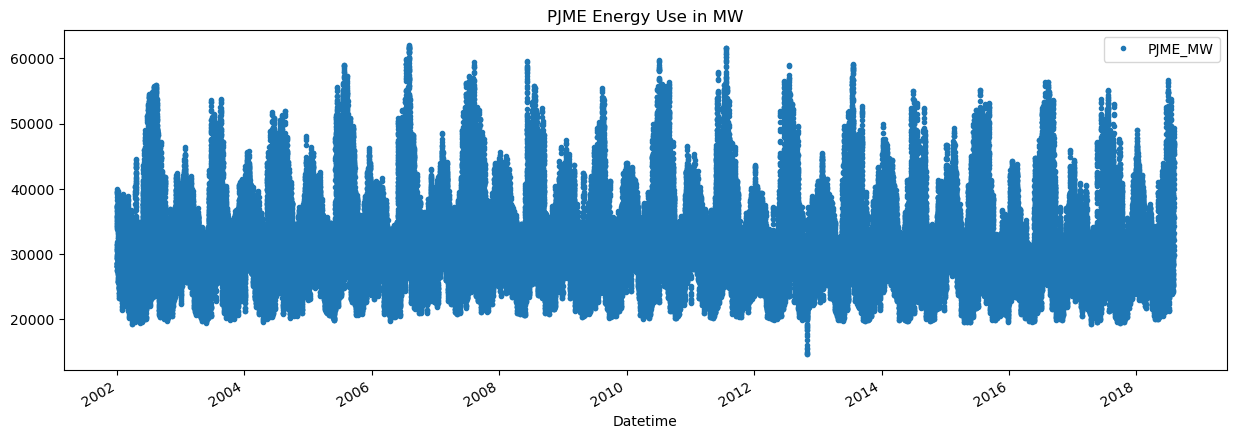

In [4]:
df.plot(style='.',
        figsize=(15, 5),
        title='PJME Energy Use in MW')
plt.show()

# 3. Outlier Detection and Removal

<AxesSubplot:ylabel='Frequency'>

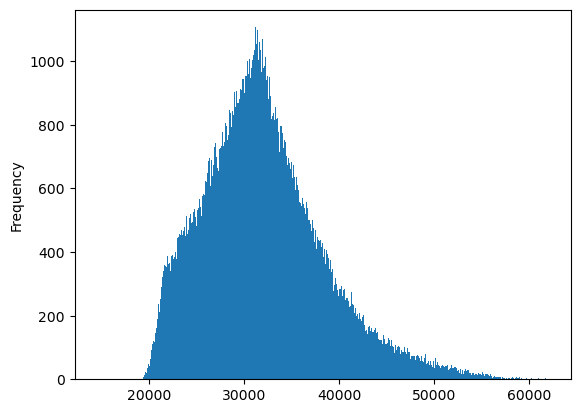

In [5]:
df['PJME_MW'].plot(kind='hist', bins=500)

<AxesSubplot:title={'center':'Outliers'}, xlabel='Datetime'>

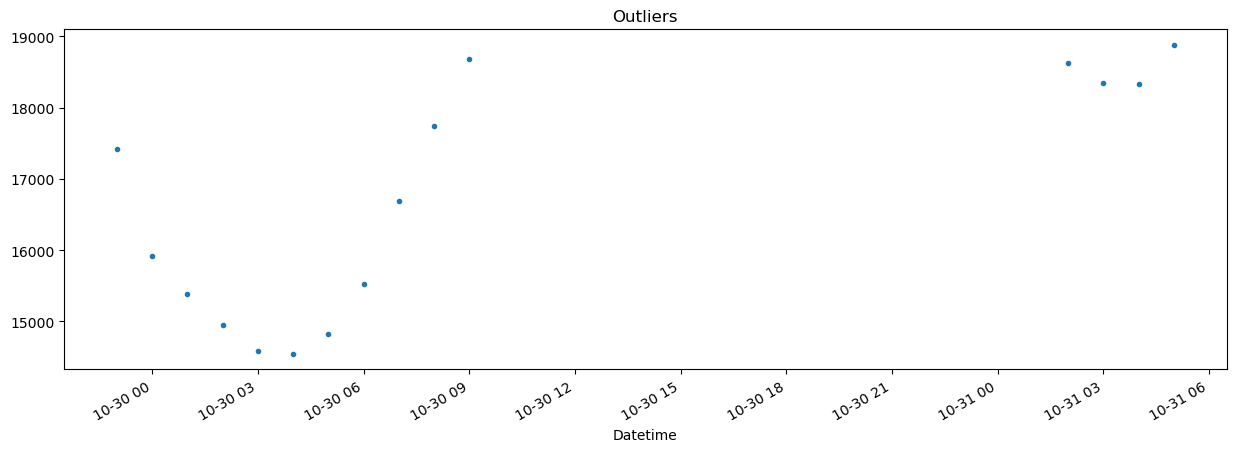

In [6]:
df.query('PJME_MW < 19_000')['PJME_MW'].plot(style='.', figsize=(15, 5), title='Outliers')

# 4. Splitting dataset

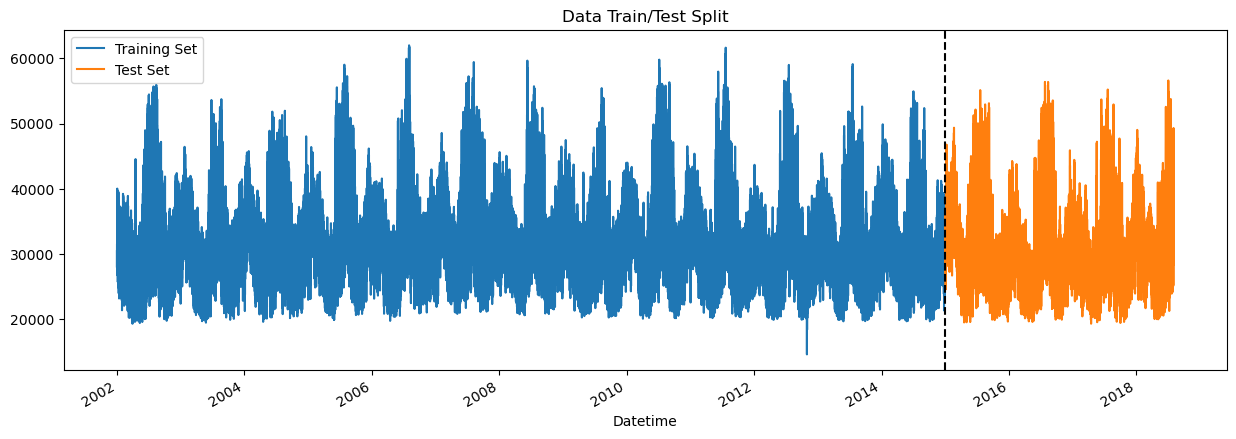

In [7]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# 5. Time Series Cross Validation

In [8]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

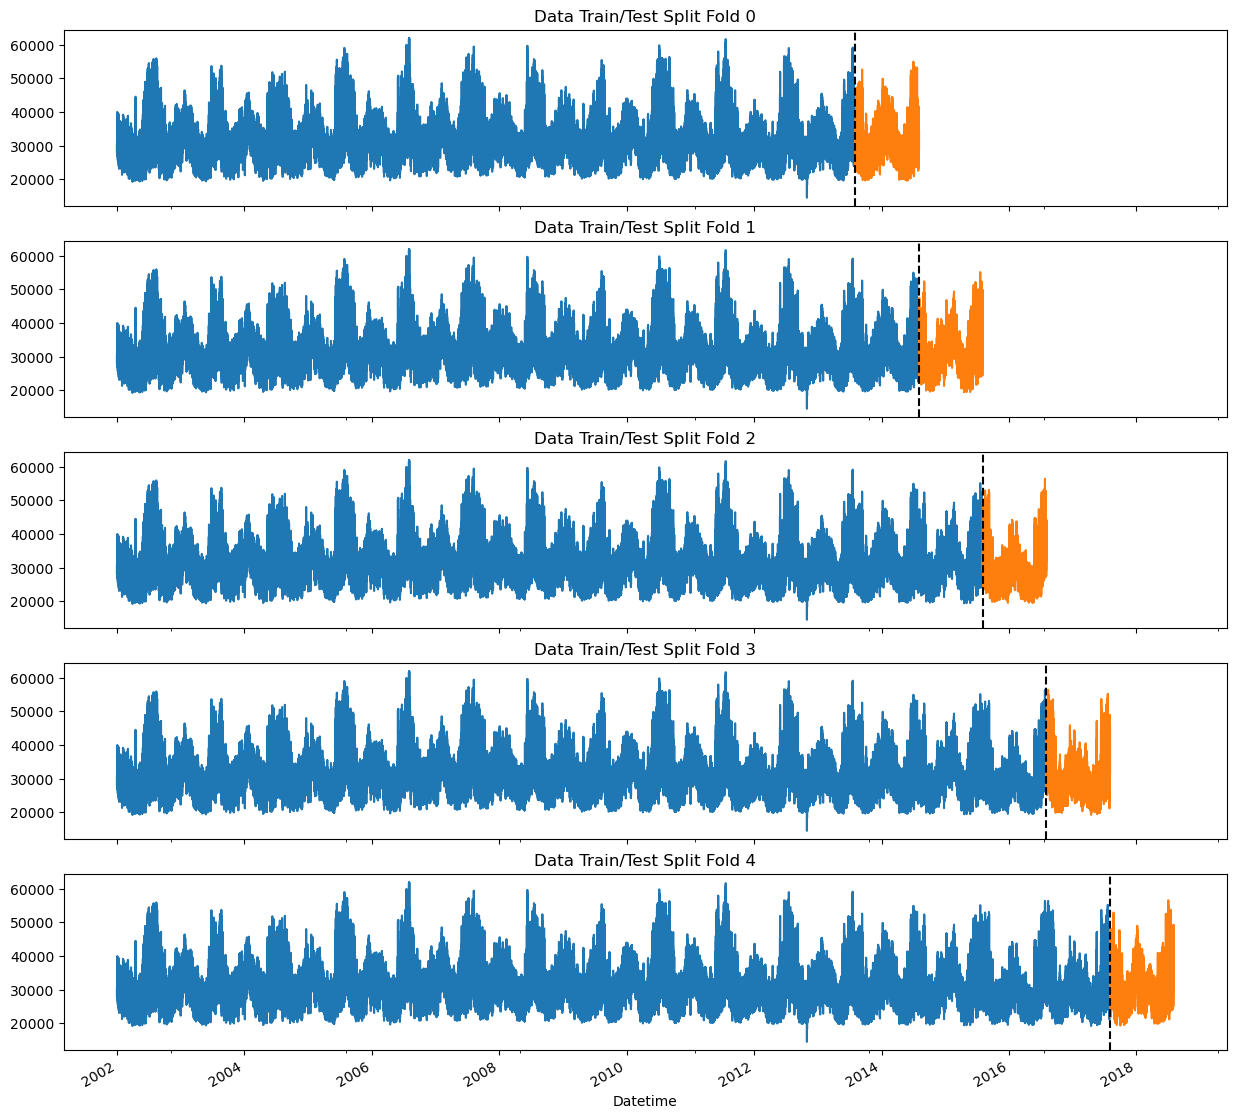

In [9]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# 6. Creating Forecast Horizon 

In [10]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# 7. Lag Features

In [11]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df
df = add_lags(df)
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN


# 8. Training

In [12]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[20:25:49] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32730.71080	validation_1-rmse:31956.74921
[100]	validation_0-rmse:12532.14250	validation_1-rmse:11907.23565
[200]	validation_0-rmse:5741.77471	validation_1-rmse:5354.04930
[300]	validation_0-rmse:3866.33091	validation_1-rmse:3895.46487
[400]	validation_0-rmse:3430.59291	validation_1-rmse:3756.68968
[451]	validation_0-rmse:3355.27181	validation_1-rmse:3762.07604
[20:26:09] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32670.51840	validation_1-rmse:32138.89448
[100]	validation_0-rmse:12513.29823	validation_1-rmse:12223.42210
[200]	validation_0-rmse:5756.41312	validation_1-rmse:5656.44699
[300]	validation_0-rmse:3906.84747	validation_1-rmse:3931.40846
[400]	validation_0-rmse:3478.73856	validation_1-rmse:3600.70642
[500]	validation_0-rmse:3357.73705	validation_1-rmse:3

In [13]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3752.7060
Fold scores:[3756.063112484651, 3420.0977816435434, 3472.8946304859937, 4118.732141420555, 3995.742451519989]


# 9. Predicting the Future

In [14]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [15]:
future_w_features = df_and_future.query('isFuture').copy()
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
future_w_features.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture,pred
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True,30304.105469
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True,28050.541016
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True,27563.199219
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True,26866.007812
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True,26595.328125


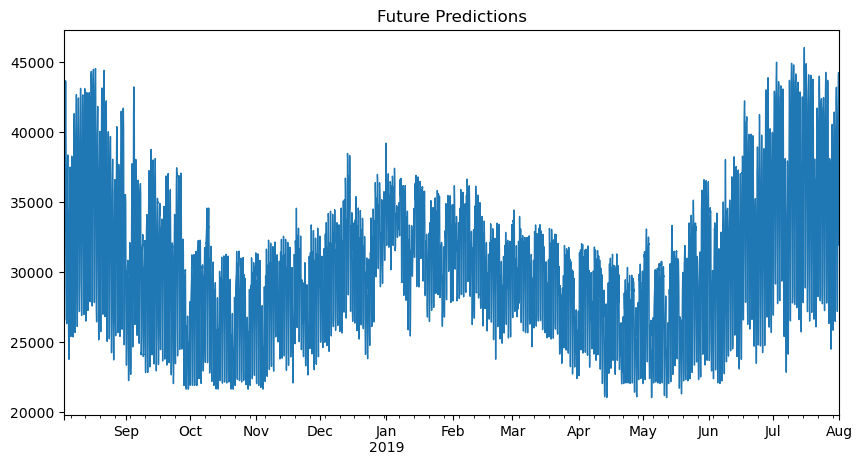

In [16]:
future_w_features['pred'].plot(figsize=(10, 5),ms=1,lw=1,title='Future Predictions')
plt.show()